# Pipeline walkthrough

## Data import

In [1]:
from preprocessing.import_data import import_save_dataset

import napari

trim_series = True
lif_test_name = "test_data/2021-06-14/p2pdpwt"
lsm_test_name = "test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1"

(
    channels_full_dataset,
    original_global_metadata,
    original_frame_metadata,
    export_global_metadata,
    export_frame_metadata,
) = import_save_dataset(lsm_test_name, trim_series=trim_series, mode="tiff")

/home/ybadal/mambaforge/envs/transcription_pipeline/lib/python3.10/site-packages/pims/bioformats.py:410: UserWarning: Due to an issue with JPype 0.6.0, reading is slower. Please consider upgrading JPype to 0.6.1 or later.
  warn('Due to an issue with JPype 0.6.0, reading is slower. '
/home/ybadal/Documents/Berkeley/github_repositories/transcription_pipeline/preprocessing/import_data.py:719: UserWarning: /home/ybadal/Documents/Berkeley/github_repositories/transcription_pipeline/test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1/collated_dataset/collated_dataset_ch00.tiff is a low contrast image
  imsave(collated_data_path, channel_data, plugin="tifffile")
/home/ybadal/Documents/Berkeley/github_repositories/transcription_pipeline/preprocessing/import_data.py:719: UserWarning: /home/ybadal/Documents/Berkeley/github_repositories/transcription_pipeline/test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1/collated_dataset/collated_dataset_ch01.tiff is a low contrast image
  imsave(collated_data_path

In [2]:
nuclear_channel_metadata = export_frame_metadata[1]
nuclear_channel = channels_full_dataset[1]

In [4]:
viewer = napari.view_image(nuclear_channel, name="Nuclear Channel")
napari.run()

## Starting a Dask Client for parallelization

In [2]:
from nuclear_analysis import segmentation
from tracking import track_features, detect_mitosis

import numpy as np
from dask.distributed import LocalCluster, Client

In [3]:
cluster = LocalCluster(
    host="localhost",
    scheduler_port=8786,
    threads_per_worker=1,
    n_workers=12,
    memory_limit="4GB",
)

In [4]:
client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 12,Total memory: 44.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:8786,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 44.70 GiB
Comm: tcp://127.0.0.1:36457,Total threads: 1
Dashboard: http://127.0.0.1:44185/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:33845,


## Nuclear segmentation and tracking

In [7]:
%%time

(
    denoised,
    denoised_futures,
    nuclear_channel_futures,
) = segmentation.denoise_movie_parallel(
    nuclear_channel,
    denoising="gaussian",
    denoising_sigma=3,
    client=client,
)

mask, mask_futures, _ = segmentation.binarize_movie_parallel(
    denoised_futures,
    thresholding="global_otsu",
    closing_footprint=segmentation.ellipsoid(3, 3),
    client=client,
    futures_in=False,
)

markers, markers_futures, _ = segmentation.mark_movie_parallel(
    *nuclear_channel_futures,  # Wrapped in list from previous parallel run, needs unpacking
    mask_futures,
    low_sigma=[3, 5.5, 5.5],
    high_sigma=[10, 14.5, 14.5],
    max_footprint=((1, 25), segmentation.ellipsoid(3, 3)),
    max_diff=1,
    client=client,
    futures_in=False,
)

marker_coords = np.array(np.nonzero(markers)).T

labels, labels_futures, _ = segmentation.segment_movie_parallel(
    denoised_futures,
    markers_futures,
    mask_futures,
    watershed_method="raw",
    min_size=200,
    client=client,
    futures_in=False,
)

segmentation_dataframe = track_features.segmentation_df(
    labels,
    nuclear_channel,
    nuclear_channel_metadata,
)

tracked_dataframe = track_features.link_df(
    segmentation_dataframe,
    search_range=15,
    # adaptive_stop=1,
    # adaptive_step=0.99,
    memory=0,
    pos_columns=["x", "y"],
    t_column="frame_reverse",
    velocity_predict=True,
    velocity_averaging=2,
)

centroids = np.unique(
    np.array(
        [
            [row["frame"] - 1, int(row["z"]), int(row["y"]), int(row["x"])]
            for _, row in tracked_dataframe.iterrows()
        ]
    ),
    axis=0,
)

mitosis_dataframe = detect_mitosis.construct_lineage(
    tracked_dataframe,
    pos_columns=["y", "x"],
    search_range_mitosis=35,
    # adaptive_stop=0.05,
    # adaptive_step=0.99,
    antiparallel_coordinate="collision",
    antiparallel_weight=None,
    min_track_length=3,
    image_dimensions=[256, 512],
    exclude_border=0.02,
    minimum_age=8,
)

reordered_labels, _, _ = track_features.reorder_labels_parallel(
    labels_futures,
    mitosis_dataframe,
    client=client,
    futures_in=False,
    futures_out=False,
)

Frame 2: 1 trajectories present.
CPU times: user 55 s, sys: 37.2 s, total: 1min 32s
Wall time: 3min 39s


Using the rule of thumb $r \approx \sigma \sqrt{2} \ (2D)$ and $r \approx \sigma \sqrt{3} \ (3D)$ as rough bounds for the kernels used for band-pass filtering seems to net a perfect segmentation.

In [9]:
viewer.add_labels(reordered_labels)

<Labels layer 'reordered_labels' at 0x7fbedc5db760>

In [10]:
_ = detect_mitosis.tracks_to_napari(
    viewer, mitosis_dataframe, name="nuclear_tracks", output=False
)

## Spot segmentation and fitting

In [6]:
transcription_channel_metadata = export_frame_metadata[0]
transcription_channel = channels_full_dataset[0]

In [7]:
viewer = napari.view_image(transcription_channel, name="Transcription Channel")
napari.run()

In [7]:
from spot_analysis import detection, fitting

In [9]:
%%time

spot_dataframe, spot_mask, bandpassed_movie = detection.detect_and_gather_spots(
    transcription_channel,
    frame_metadata=transcription_channel_metadata,
    low_sigma=[0.1, 0.5, 0.5],
    high_sigma=[3, 1.5, 1.5],
    threshold="triangle",
    min_size=6,
    connectivity=1,
    span=[5, 11, 11],
    pos_columns=["z", "y", "x"],
    return_bandpass=False,
    return_spot_mask=True,
    drop_reverse_time=True,
    client=client,
)

fitting.add_fits_spots_dataframe_parallel(
    spot_dataframe,
    sigma_x_y_guess=1.5,
    sigma_z_guess=2,
    client=client,
    amplitude_guess=None,
    offset_guess=None,
    method="trf",
    inplace=True,
)

CPU times: user 12.4 s, sys: 4.19 s, total: 16.5 s
Wall time: 32.2 s


In [10]:
spot_dataframe

,label,z,y,x,frame,t_s,t_frame,raw_spot,coordinates_start,sigma_x_y,sigma_z,amplitude,offset,cost,norm_cost
0,436,5.901674,60.149073,308.473986,1,4.305350,0,"[[[1601, 1631, 1418, 1034, 1458, 1227, 680, 15...","[0, 3, 54, 303]",0.842110,0.690278,4478.519850,1265.532016,4.714938e+07,0.003584
1,460,6.804033,170.582886,373.563045,1,4.949140,0,"[[[1668, 1243, 1281, 2169, 1157, 1535, 1252, 1...","[0, 4, 165, 368]",0.822731,0.772539,12564.859584,1329.326717,5.583090e+07,0.001390
2,534,8.292465,194.814295,441.438253,1,6.018243,0,"[[[686, 967, 917, 719, 1047, 1123, 1219, 1489,...","[0, 5, 189, 436]",0.937308,1.175249,5518.803202,1276.559538,9.960894e+07,0.004227
3,567,8.168442,79.621817,359.829120,1,6.017945,0,"[[[2428, 2190, 1674, 1763, 1630, 1335, 751, 13...","[0, 5, 74, 354]",0.779898,0.579760,8176.736835,1299.954783,4.764916e+07,0.001973
4,608,9.640556,75.397543,459.921324,1,7.221961,0,"[[[577, 857, 806, 918, 1564, 874, 731, 759, 10...","[0, 7, 69, 454]",0.721118,0.806929,8662.793622,1234.451368,5.991820e+07,0.002089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9956,642,19.532418,177.925660,508.105274,167,2851.964126,171,None,"[166, 17, 172, 503]",NaN,NaN,NaN,NaN,NaN,NaN
9957,643,19.182461,186.435138,453.489373,167,2851.226889,171,"[[[1240, 1086, 733, 1062, 1252, 916, 1485, 138...","[166, 16, 180, 448]",0.867353,0.743386,3151.446235,915.232683,2.799095e+07,0.003924
9958,644,19.575712,218.160415,404.667220,167,2851.429367,171,"[[[764, 436, 538, 986, 418, 901, 995, 402, 624...","[166, 16, 212, 399]",1.097206,1.026536,2074.474689,846.409076,2.769652e+07,0.005930
9959,649,19.666003,109.451826,171.390705,167,2852.069727,171,None,"[166, 17, 104, 166]",NaN,NaN,NaN,NaN,NaN,NaN


## Filtering spots based on fits

In [23]:
import matplotlib.pyplot as plt
import scipy.stats as st

### Normalized cost

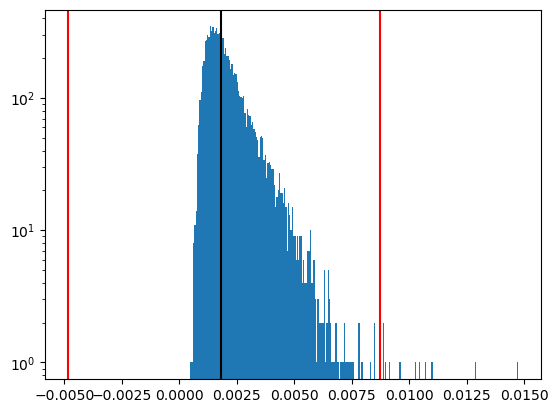

In [117]:
norm_cost_quantiles = spot_dataframe["norm_cost"].quantile([0.25, 0.5, 0.75])
norm_cost_iqr = norm_cost_quantiles[0.75] - norm_cost_quantiles[0.25]

k = 6
fences = (
    norm_cost_quantiles[0.25] - k * norm_cost_iqr,
    norm_cost_quantiles[0.75] + k * norm_cost_iqr,
)

bins_norm_cost, hist_norm_cost, plot_norm_cost = plt.hist(
    spot_dataframe["norm_cost"], bins=256, log=True
)

plt.axvline(x=norm_cost_quantiles[0.5], color="k")
plt.axvline(x=fences[0], color="r")
plt.axvline(x=fences[1], color="r")

Due to the right-skewness and low apparent discriminating power, I don't think normalized cost is a good parameter for threshold filtering. I can't think of a good way to automate it, and even doing it manually seems non-ideal. We could try to use it to pick between multiple spots in the same nucleus?

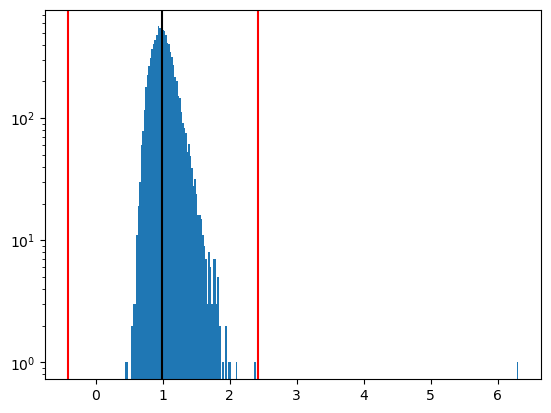

In [118]:
sigma_x_y_quantiles = spot_dataframe["sigma_x_y"].quantile([0.25, 0.5, 0.75])
sigma_x_y_iqr = sigma_x_y_quantiles[0.75] - sigma_x_y_quantiles[0.25]

k = 6
fences = (
    sigma_x_y_quantiles[0.25] - k * sigma_x_y_iqr,
    sigma_x_y_quantiles[0.75] + k * sigma_x_y_iqr,
)

sigma_x_y_cost, hist_sigma_x_y, plot_sigma_x_y = plt.hist(
    spot_dataframe["sigma_x_y"], bins=256, log=True
)

plt.axvline(x=sigma_x_y_quantiles[0.5], color="k")
plt.axvline(x=fences[0], color="r")
plt.axvline(x=fences[1], color="r")

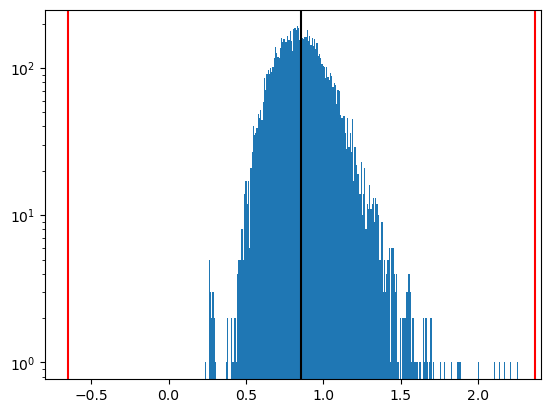

In [122]:
sigma_z_quantiles = spot_dataframe["sigma_z"].quantile([0.25, 0.5, 0.75])
sigma_z_iqr = sigma_z_quantiles[0.75] - sigma_z_quantiles[0.25]

k = 6
fences = (
    sigma_z_quantiles[0.25] - k * sigma_z_iqr,
    sigma_z_quantiles[0.75] + k * sigma_z_iqr,
)

sigma_z_cost, hist_sigma_z, plot_sigma_z = plt.hist(
    spot_dataframe["sigma_z"], bins=256, log=True
)

plt.axvline(x=sigma_z_quantiles[0.5], color="k")
plt.axvline(x=fences[0], color="r")
plt.axvline(x=fences[1], color="r")

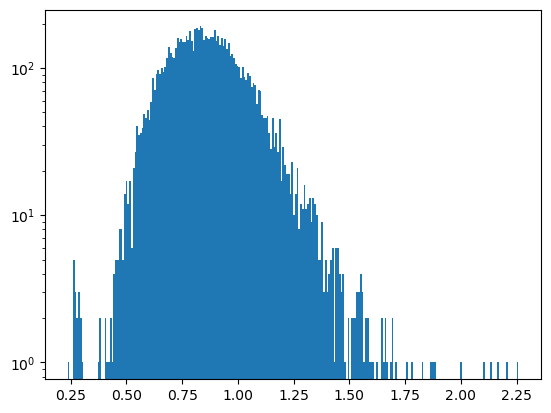

In [125]:
bins_sigma_z, hist_sigma_z, plot_sigma_z = plt.hist(
    spot_dataframe["sigma_z"], bins=256, log=True
)

In [108]:
from skimage.filters import threshold_otsu

In [114]:
threshold_otsu(spot_dataframe["sigma_z"].dropna().values)

0.8876607880507739

After some messing around, I think it might be best to implement a very lax threshold based on zero-crossings of the histograms, searching in both directions from the median. This can also be done asymetrically, with a higher threshold for zero-crossings on the right-side to account for the fat right-tail. If a nuclear mask is supplied, it's best to delay the filtering step until spots outside the nuclear mask have been excluded in case that makes the zero-crossing more obvious. If it makes the zero-crossings disappear, then they shouldn't be used to filter anyway.